In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

# self-consistent solution of $sech^2$ electron hole

In [438]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 600


vmax = 10 # 速度最大值
nx = 1000
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## sech2分布
$$ f_u(w>0) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(\pm \sqrt{2w}+u)^2 } $$
$$ f_t(w<0) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}u^2} [1 - (1-u^2)w] $$
其中$w=v^2/2-\phi$
## 理论自洽解
$$ \phi = \psi sech^2 \left(\frac{\sqrt{B_s}x}{2}\right) $$
$$ B_s = 1 + \frac{u}{\sqrt{2}} Z\left(\frac{u}{\sqrt{2}}\right) $$
$$ D_s = \frac{(3-u^2)B_s-1}{2} $$

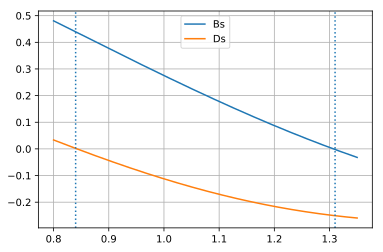

In [439]:
u = np.linspace(0.8,1.35,num=200)
Bs = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
Ds = ( (3-u**2)*Bs-1.0 )/4.0
psi = -3.0*Bs/Ds/2.0

ul = 0.84
ur = 1.31

plt.plot(u,Bs,label='Bs')
plt.plot(u,Ds,label='Ds')
plt.axvline(ul,linestyle=':')
plt.axvline(ur,linestyle=':')

plt.legend()
plt.grid()
plt.show()

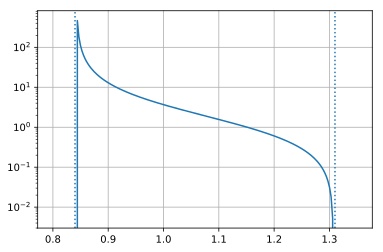

In [440]:
plt.plot(u,psi)
plt.axvline(ul,linestyle=':')
plt.axvline(ur,linestyle=':')
plt.yscale('log')
plt.grid()
plt.show()

In [441]:
u = 1.305
Bs = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
Ds = ( (3-u**2)*Bs-1.0 )/4.0
psi = -3.0*Bs/Ds/2.0
delta = 2.0/np.sqrt(Bs)
print('delta',delta)
print('psi  ',psi)

delta 52.01572049910173
psi   0.008887416609194438


In [442]:
Es = -8.0/45.0/np.sqrt(np.pi)*np.exp(-u**2/2)*(u**4-6*u**2+3)
xi = u/np.sqrt(2)
Z = plasmapy.dispersion.plasma_dispersion_func(xi).real
Z1 = -2*(1+xi*Z)
Z2 = -2*(Z+xi*Z1)
Z3 = -2*(2*Z1+xi*Z2)
Z4 = -2*(3*Z2+xi*Z3)
Z5 = -2*(4*Z3+xi*Z4)
Fs = -Z5/384.0

In [443]:
def psieq(p):
    return Bs/2.0 + Ds/3.0 * p + 2.0/7.0*Es*p**(1.5) + Fs/4 * p**2

In [460]:
sol = op.root(psieq,psi)
psi_new = sol.x[0]
print(sol.success,psi_new)

True 0.009440212115740523


In [445]:
xp = (x-L/2)/delta
phi = (1.0+0.1)*psi_new*np.cosh(xp)**(-2)
c1 = phi[0]
c2 = phi[-1]

In [446]:
@nb.jit
def nonvec_f_fun_sech2(v,phi):
    r = 0
    v_waveframe = v
    w = (v_waveframe**2)/2-phi
    if w>0:
        if v_waveframe<=-(2*phi)**0.5:
            r=math.exp(-(-(2*w)**0.5+u)**2/2) 
        elif v_waveframe>(2*phi)**0.5:
            r=math.exp(-( (2*w)**0.5+u)**2/2) 
    else:
        r = math.exp(-u**2/2)*(1+(-w)*(1-u**2))
    return r/(2*np.pi)**0.5
f_fun_sech2 = np.vectorize(nonvec_f_fun_sech2)

In [447]:
for count in tqdm(range(10)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech2(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    
#     # natural BC
#     laplace[0][0]=-1
#     laplace[-1][-1]=-1
    
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    
    # Dirichlet BC phi[0]=c1 phi[-1]=c2
    r[0]  += c1
    r[-1] += c2
    
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-6:
        print("Sucess! Iteration counts =", count)
#         print("err =", err)
        break
print(err)

 20%|███████████▊                                               | 2/10 [00:01<00:04,  1.79it/s]

Sucess! Iteration counts = 2
4.3837855603537653e-07


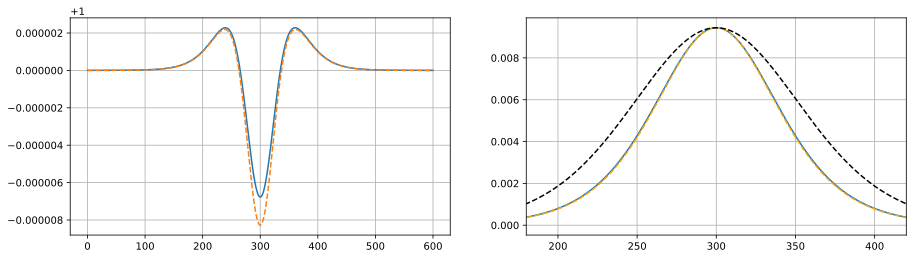

In [448]:
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.plot(x,1+Bs*psi_new*np.cosh((x-L/2)/delta)**(-2)+Ds*psi_new**2*np.cosh((x-L/2)/delta)**(-4),linestyle='--')
ax1.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi)
ax3.plot(x,psi_new*np.cosh((x-L/2)/delta)**(-2),color='orange',linestyle='--')
ax3.plot(x,psi_new*np.cosh((x-L/2)/delta/2.0)**(-4),color='black',linestyle='--')
ax3.grid()
ax3.set_xlim(0.3*L,0.7*L)
# ax3.set_yscale('log')
plt.show()

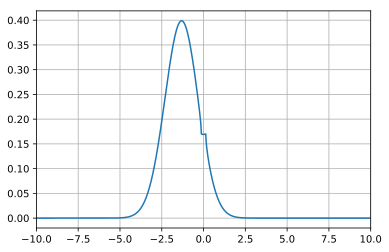

In [449]:
V,Phi=np.meshgrid(v,phi)
f_matrix = f_fun_sech2(V,Phi)
fv = f_matrix.sum(axis=0)*dx/L
plt.plot(v,f_matrix[int(nx/2),])
plt.xlim(-10,10)
# plt.ylim(0.05,0.31)
plt.grid()

In [450]:
def phi4_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-4)

def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para4,pcov=curve_fit(phi4_theo,x,phi)
para2,pcov=curve_fit(phi2_theo,x,phi)
Ddelta = round(abs(para2[1]-delta)/para2[1]*100,2)
Dpsi = round(abs(para2[0]-psi)/para2[0]*100,2)  
Dpsi_new = round(abs(para2[0]-psi_new)/para2[0]*100,2)  

print('sech4 fit:',para4)
print('sech2 fit:',para2)
print('Dpsi     :',Dpsi,'%')
print('Ddelta   :',Ddelta,'%')
print('Dpsi_new:',Dpsi_new,'%')

sech4 fit: [9.32086501e-03 7.87897979e+01]
sech2 fit: [9.45066457e-03 5.25723168e+01]
Dpsi     : 5.96 %
Ddelta   : 1.06 %
Dpsi_new: 0.11 %


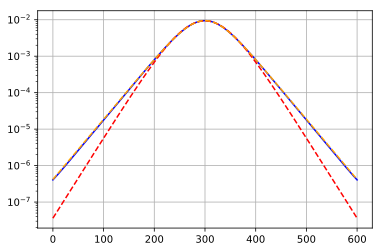

In [451]:
plt.plot(x,phi,color='blue')
plt.plot(x,phi4_theo(x,para4[0],para4[1]),'--',color='red')
plt.plot(x,phi2_theo(x,para2[0],para2[1]),'--',color='orange')
# plt.plot(x,phi2_theo(x,psi,delta),color='orange')
# plt.xlim(0.3*L,0.7*L)
# plt.ylim(2e-3,5e-3)
plt.yscale('log')
plt.grid()
plt.show()

In [433]:
mat.append([u,round(para2[1],3),round(delta,3),Ddelta,round(para2[0],3),round(psi,3),round(psi_new,3),Dpsi,Dpsi_new])

In [434]:
table = PrettyTable(['u','delta_sc','delta_th','delta_err(%)','psi_sc','psi_th','psi_th_new','psi_err(%)','psi_new_err(%)'])
for i in range(len(mat)):
    table.add_row(mat[i])
print(table)

+-------+----------+----------+--------------+--------+--------+------------+------------+----------------+
|   u   | delta_sc | delta_th | delta_err(%) | psi_sc | psi_th | psi_th_new | psi_err(%) | psi_new_err(%) |
+-------+----------+----------+--------------+--------+--------+------------+------------+----------------+
|  1.25 |  10.059  |  9.413   |     6.43     | 0.426  |  0.29  |    0.4     |   31.94    |      6.03      |
|  1.26 |  11.03   |  10.399  |     5.73     | 0.329  | 0.234  |   0.315    |   28.89    |      4.2       |
|  1.27 |  12.375  |  11.759  |     4.98     | 0.243  | 0.181  |   0.236    |   25.56    |      2.74      |
|  1.28 |  14.415  |  13.813  |     4.18     | 0.166  | 0.129  |   0.163    |   21.81    |      1.62      |
|  1.29 |  18.063  |  17.477  |     3.25     | 0.097  |  0.08  |   0.096    |   17.33    |      0.82      |
|  1.3  |  27.975  |  27.404  |     2.04     | 0.036  | 0.032  |   0.036    |   11.17    |      0.3       |
| 1.305 |  52.898  |  52.016

In [435]:
# mat = mat[0:-1]
# mat = []

In [458]:
psi_last = psi
psi_next = psi_last * (1.0 - psi_last**0.5*(6*Es/7/Ds) - psi_last*(3*Fs/Ds/4))
# psi_last = psi_next
# psi_new_appro = psi * (1.0 - psi**0.5*(6*Es/7/Ds) - psi*(3*Fs/Ds/4))
print(psi)
print(psi_next)
print(para2[0])

0.008887416609194438
0.009393176838626689
0.009450664566769816


In [459]:
abs(psi_next-para2[0])/para2[0]*100

0.6082929696316217